### Growth factor-mediated coupling between lineage size and cell fate choice underlies robustness of mammalian development

#### N. Saiz, L. Mora-Bitria, S. Rahman, H. George, J.P. Herder, J. García-Ojalvo and A.-K. Hadjantonakis

**Figure 2c**

This code reproduces the average lineage dynamics of our minimal model of EPI-PrE cell fate choice in the early embryo, when running of a set of proliferating cells represented by the agent-based model described in the Methods section. Running this code requires the C compiler `cc`.

First, we load all necessary packages:

In [1]:
import numpy as np
from IPython.display import clear_output
import subprocess
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20

Now we compile the C code:

In [2]:
try:
    out = subprocess.check_output('make --file=Makefile_v1 clean', shell=True)
    outlist = out.decode().split('\n')
    for outline in outlist:
        print(outline)
except:
    pass

p = subprocess.Popen(["make","--file=Makefile_v1"],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
while True:
    ln = p.stdout.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)
while True:
    ln = p.stderr.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)

rm *.o

cc -O3 -c dran.c -o dran.o
cc -O3 -c embryo_v1.c
cc embryo_v1.o dran.o -o embryo_v1 -lm


We now define a function `run` that generates the parameter value file and runs the C code. Some of the parameters are introduced as arguments to the function, the rest are hard-coded within it.

In [3]:
def run(nruns=10,alpha=10,Kf=1,nth=0.6,gth=0.4,n0=3,n0sd=0.5,
        N2start=12,N2startsd=1,N2ablate=30,fate2ablate=3,p2ablate=0.3,
        mt=0.01,rntd=0.01,nth2=0.9,gth2=0.1,Nmax=50):
    fname = 'output/dset_v1_%i'%rngseed
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('%s    maximum_cell_number\n'%Nmax)
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('300.0         final_time\n')
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          mean_cell_number_to_start_biochemistry\n'%N2start)
    pfile.write('%s          std_cell_number_to_start_biochemistry\n'%N2startsd)
    pfile.write('%s          cell_number_to_start_ablation\n'%N2ablate)
    pfile.write('%s          cell_type_to_ablate\n'%fate2ablate)
    pfile.write('%s          cell_fraction_to_ablate\n'%p2ablate)
    pfile.close()

    p = subprocess.Popen(['time','embryo_v1',fname],
                         stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

Next we define two plotting functions:

In [4]:
def plot_fractions_vs_cell_number():
    fname = 'output/dset_v1_%i'%rngseed
    Nvec = []
    fdpvec = []
    fepivec = []
    fprevec = []
    fdp2vec = []
    fepi2vec = []
    fpre2vec = []
    if nruns>1:
        sddpvec = []
        sdepivec = []
        sdprevec = []
    data = open(fname+'_binned.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
        Nvec.append(snap[0])
        fdpvec.append(snap[1]*100)
        fepivec.append(snap[2]*100)
        fprevec.append(snap[3]*100)
        fdp2vec.append(snap[4]*100)
        fepi2vec.append(snap[5]*100)
        fpre2vec.append(snap[6]*100)
        if snap[4]<snap[1]**2:
            print('dp',snap[1],snap[1]**2,snap[4],'N =',snap[0])
        if snap[5]<snap[2]**2:
            print('epi',snap[2],snap[2]**2,snap[5],'N =',snap[0])
        if snap[6]<snap[3]**2:
            print('pre',snap[3],snap[3]**2,snap[6],'N =',snap[0])
        if nruns>1:
            sddpvec.append(np.sqrt(snap[4]-snap[1]**2)*100)
            sdepivec.append(np.sqrt(snap[5]-snap[2]**2)*100)
            sdprevec.append(np.sqrt(snap[6]-snap[3]**2)*100)
    if nruns>1:
        plt.errorbar(Nvec,fdpvec,yerr=sddpvec,capsize=4,fmt='om-',label='DP')
        plt.errorbar(Nvec,fepivec,yerr=sdepivec,capsize=4,fmt='or-',label='EPI')
        plt.errorbar(Nvec,fprevec,yerr=sdprevec,capsize=4,fmt='ob-',label='PrE')
    else:
        plt.plot(Nvec,fdpvec,'om-',label='DP')
        plt.plot(Nvec,fepivec,'or-',label='EPI')
        plt.plot(Nvec,fprevec,'ob-',label='PrE')
    plt.xlabel('ICM cell count')
    plt.ylabel('% of ICM')
    plt.xlim([8,50])
    plt.ylim([-2,102])
    plt.axhline(50,color='k',linestyle='--')
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig('fig2c_wrt_cell_number.pdf')
    plt.show()
    
def plot_fractions_vs_time(N2ablate=30,fate2ablate=3,nruns=1,p2ablate=0.3,
                           title=False,tmin=40*90/56,tmax=60*90/56,
                           tshift=0,nmin=-1,nmax=50):
    tscale = 90/56
    fname = 'output/dset_v1_%i'%rngseed
    tvec = []
    fdpvec = []
    fepivec = []
    fprevec = []
    fdp2vec = []
    fepi2vec = []
    fpre2vec = []
    Nvec = []
    if nruns>1:
        sddpvec = []
        sdepivec = []
        sdprevec = []
        sdNvec = []
    data = open(fname+'.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
        tvec.append(snap[0]+tshift)
        fdpvec.append(snap[1]*100)
        fepivec.append(snap[2]*100)
        fprevec.append(snap[3]*100)
        fdp2vec.append(snap[4]*100)
        fepi2vec.append(snap[5]*100)
        fpre2vec.append(snap[6]*100)
        Nvec.append(snap[7])
        if nruns>1:
            sddpvec.append(np.sqrt(snap[4]-snap[1]**2)*100)
            sdepivec.append(np.sqrt(snap[5]-snap[2]**2)*100)
            sdprevec.append(np.sqrt(snap[6]-snap[3]**2)*100)
            sdNvec.append(np.sqrt(snap[8]-snap[7]**2))
    if fate2ablate == 0:
        abtype = 'DP'
    if fate2ablate == 1:
        abtype = 'EPI'
    if fate2ablate == 2:
        abtype = 'PrE'
    if fate2ablate == 3:
        abtype = 'Random'
    plt.figure()
    ax1 = plt.gca()
    if title:
        ax1.title('%s, %s-cell stage, %s runs, %s fraction'%(abtype,N2ablate,nruns,p2ablate),fontsize=15)
    ax2 = ax1.twinx()
    if nruns>1:
        ax1.errorbar(np.asarray(tvec)*tscale,fdpvec,yerr=sddpvec,capsize=4,fmt='om-',label='DP')
        ax1.errorbar(np.asarray(tvec)*tscale,fepivec,yerr=sdepivec,capsize=4,fmt='or-',label='EPI')
        ax1.errorbar(np.asarray(tvec)*tscale,fprevec,yerr=sdprevec,capsize=4,fmt='ob-',label='PrE')
        ax2.errorbar(np.asarray(tvec)*tscale,Nvec,yerr=sdNvec,fmt='o-',color='grey',label='all')
    else:
        ax1.plot(np.asarray(tvec)*tscale,fdpvec,'m-',label='DP')
        ax1.plot(np.asarray(tvec)*tscale,fepivec,'r-',label='EPI')
        ax1.plot(np.asarray(tvec)*tscale,fprevec,'b-',label='PrE')
        ax2.plot(np.asarray(tvec)*tscale,Nvec,'grey',label='all')
    if N2ablate<100:
        ax2.axhline(N2ablate,color='k',linestyle=':')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize=15)
    ax1.axhline(50,color='k',linestyle='--')
    ax1.set_xlabel('time (hpf)')
    ax1.set_ylabel('% of ICM')
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([-2,102])
    ax2.set_ylabel('cell number', rotation=270, labelpad=20, color='grey')
    ax2.tick_params(axis='y', colors='grey')
    ax2.set_ylim([nmin,nmax])
    plt.tight_layout()
    plt.savefig('fig2c_%s_runs.pdf'%nruns)
    plt.show()

Using the functions defined above, now we run the simulations for an ensemble of realizations, and plot the average number of cells in each lineage, as a function of time.

       46.36 real        41.53 user         0.49 sys


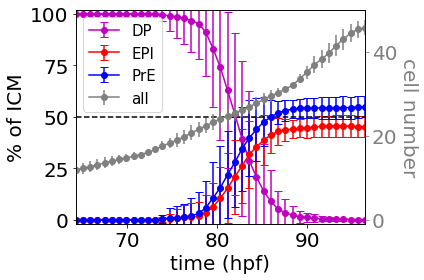

In [5]:
N2ablate = 100      # Number of cells at which ablation happens,
                    # irrelevant here since the number is higher than
                    # the cell number at which the simulation is stopped
fate2ablate = 3     # Unused
p2ablate = 0.3      # Unused 

nruns = 100         # Number of simulation runs
rngseed = 1200      # Seed of random number generator

run(nruns=nruns, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=3, n0sd=0,
    N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    N2start=20, N2startsd=2, mt=0.5)

plot_fractions_vs_time(N2ablate=N2ablate,fate2ablate=fate2ablate,
                       nruns=nruns,p2ablate=p2ablate)

We now do the simulation for a single realization:

        0.60 real         0.56 user         0.02 sys


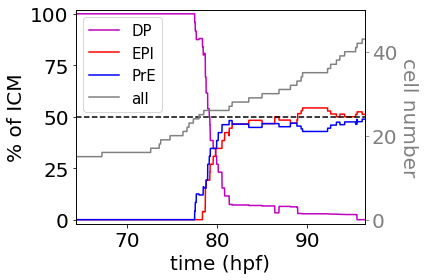

In [6]:
nruns = 1                # Number of simulation runs

run(nruns=nruns, alpha=10, Kf=0.9, N2ablate=N2ablate,
    fate2ablate=fate2ablate, p2ablate=p2ablate, nth=0.8, gth=0.2,
    n0=3, n0sd=0, N2start=20, N2startsd=2, mt=0.01)

plot_fractions_vs_time(N2ablate=N2ablate,fate2ablate=fate2ablate,
                       nruns=nruns,p2ablate=p2ablate)

And finally we plot the results as a function of the number of cells in the ICM, instead of as a function of time.

       34.72 real        34.30 user         0.10 sys


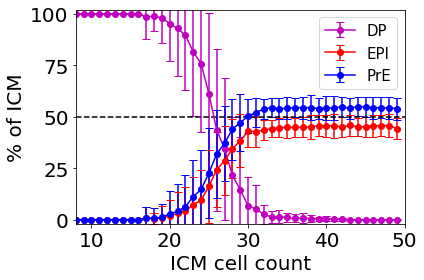

In [7]:
nruns = 100                # Number of simulation runs

run(nruns=nruns, alpha=10, Kf=0.9, N2ablate=N2ablate, fate2ablate=fate2ablate,
    p2ablate=p2ablate, nth=0.8, gth=0.2, n0=3, n0sd=0, N2start=20, N2startsd=2)

plot_fractions_vs_cell_number()